# Actividad Brazo

El brazo consiste de 5 servos marca Dynamixel y modelo XL430-W250. Durante el laboratorio correspondiente a este brazo tendrán que hacer múltiples tareas con él, y la idea de esta actividad es que se familiaricen un poco con su funcionamiento y qué cosas se pueden hacer.

## Correr Driver

Para correr el driver primero deben conectar el robot a su computador, y luego "pasar" la conexión a VirtualBox. Con el brazo conectado, deben ir al menú de la máquina virtual en VirtualBox -> Devices -> USB y luego seleccionar el brazo (FTDI USB <-> Serial Converter). Luego, deben abrir un Terminal (Ctrl+Alt+T) y correr los tres comandos siguientes:
```shell
cd ~/Desktop/ICM3833/icm3833-bin_x86_64/drivers/binaries
git pull # les va a pedir usuario y contraseña de bitbucket
./brazo_driver
```

Este driver es el encargado de traducir toda la actividad del brazo a LCM: puede recibir comandos a través de ahí, y también manda información respecto a su situación actual a través de la misma plataforma. Cada vez que necesiten trabajar con el brazo, tendrán que tener una pestaña del terminal con el driver corriendo. De lo contrario, no se podrán comunicar a través de LCM con el mismo.

## Envío de comandos por LCM

El brazo robótico puede recibir dos tipos de comandos: mensajes de posición de motores o mensajes de configuración. Ustedes sobre todo usarán el mensaje de comando a los motores.

### Posiciones de motores

Para modificar las posiciones de los motores, usaremos los tipos LCM `dynamxel_command_t` y `dynamixel_command_list_t`. Ese último es simplemente una lista de comandos, que se usa para poder mandar comandos a múltiples comandos de una sola vez. Por ejemplo, para mandar al robot a la posición de servos: $\theta_1 = \pi/2, \theta_2=0,\theta_3=\pi/2, \theta_4 = -\pi/2$, hacemos: 


In [21]:
import lcm
from lcmtypes.dynamixel_command_list_t import dynamixel_command_list_t as dyn_comm_list
from lcmtypes.dynamixel_command_t import dynamixel_command_t as dyn_comm
import time
from math import pi

comm_list = dyn_comm_list()
comm_list.len = 0
ids = [1,2,3,4]
angles = [0, 0, 0, 0]


for id_servo,angle in zip(ids,angles):
    comm = dyn_comm()
    comm.utime = int(time.time() * 1000000)
    comm.servo_id = id_servo
    comm.max_torque = 1.0
    comm.position_radians = angle
    # Este valor se sobreescibirá con el control interno del motor, no es necesario escribirlo:
    comm.speed = 0
    
    # Se agrega a la lista de comandos
    comm_list.commands.append(comm)
    comm_list.len += 1

lc = lcm.LCM()
lc.publish("ARM_COMMAND", comm_list.encode())

### Cambio de PID
Cada motor tiene un control PID interno, que se resetea cada vez que se prende. Para "mantener" los valores constantes, el driver lee de un archivo de configuración cada vez que se corre, y setea los valores de PID según ese archivo. Pueden editar este archivo si quieren: en `~/Desktop/ICM3833/icm3833-bin_x86_64/common/config_files/brazo_v2_config.json`. Este contiene otras configuraciones que les pueden ser útiles durante el desarrollo de los laboratorios.

## Lectura de información por LCM

El brazo está constantemente publicando información respecto a su estado actual: posiciones de todos los servos, temperatura, velocidad, carga, flags de error, entre otros. Para ver el estado del robot tienen dos opciones: usar la herramienta LCM Spy o trabajar directamente con el mensaje en Python.

### LCM Spy
Si tienen el driver corriendo, pueden ver información del brazo abriendo una nueva ventana/pestaña de terminal y corriendo `lcm-spy`.

### Mensajes LCM
Se puede obtener información del brazo leyendo por Python los mensajes de status del robot que llegan a través de LCM. 

In [112]:
import lcm
from lcmtypes.dynamixel_status_list_t import dynamixel_status_list_t as dyn_status_list
from lcmtypes.dynamixel_status_t import dynamixel_status_t as dyn_status
import time

def status_handler(channel, data):
    status_list = dyn_status_list.decode(data)
    print("######################")
    for status in status_list.statuses:
        print("------------\nID: {},\nangle_radians: {:.3f},\nerror_flags: {}\n------------".format(
            status.servo_id, status.position_radians, status.error_flags)
        )
    print("######################")

lc = lcm.LCM()
lc.subscribe("ARM_STATUS", status_handler)
lc.handle()

######################
------------
ID: 1,
angle_radians: 0.003,
error_flags: 0
------------
------------
ID: 2,
angle_radians: 1.598,
error_flags: 0
------------
------------
ID: 3,
angle_radians: 0.014,
error_flags: 0
------------
------------
ID: 4,
angle_radians: 0.005,
error_flags: 0
------------
------------
ID: 5,
angle_radians: 0.006,
error_flags: 0
------------
######################


# Actividad

La actividad será muy simple: habrán tres posiciones objetivo, y para cada una deberán:
1. Mover el robot a esa posición (a través de LCM)
2. Leer la posición que están entregando los motores (a través de LCM)
3. Calcular matriz homogénea de transformación con la posición entregada (usando lo de la actividad de FK teórico)
4. Graficar posición x,y,z real respecto a un frame fijo (última columna de matriz de tranformación)
5. Medir qué tan cerca de esa posición quedo el *gripper* del robot en la realidad

Las posiciones son las siguientes:
$$
\theta_1=\begin{bmatrix} \pi/2 \\ \pi/4 \\ \pi/2 \\ -\pi/4 \end{bmatrix}
\theta_2=\begin{bmatrix} 0 \\ \pi/2 \\ -\pi/2 \\ \pi/2 \end{bmatrix}
\theta_3=\begin{bmatrix} -\pi/4 \\ \pi/4 \\ -\pi/4 \\ \pi/4 \end{bmatrix}
$$

Al final de la actividad deberán crear una carpeta `talleres` dentro de su repositorio, y dentro de esta otra llamada `20190829`. En esta deben copiar este notebook y el de la actividad de FK teórica y luego hacer `git add -A`, `git commit -m "tutorial brazo terminado"` y `git push`.

In [113]:
from math import pi
import modern_robotics as mr
import numpy as np
from time import sleep

### 1. Enviar posición al brazo

In [124]:
comm_list = dyn_comm_list()
comm_list.len = 0
ids = [1,2,3,4]
angles_list= []
angles_list.append([pi/2, pi/4, pi/2, -pi/4])
angles_list.append([0, pi/2,-pi/2, pi/2])
angles_list.append([-pi/4, pi/4, -pi/4, pi/4])

def status_handler(channel, data):
    status_list = dyn_status_list.decode(data)
    for status in status_list.statuses:
        meas_angles.append(status.position_radians)
        
meas_angles_list=[]


for angles in angles_list:
    comm_list = dyn_comm_list()
    comm_list.len = 0
    for id_servo,angle in zip(ids,angles):
        comm = dyn_comm()
        comm.utime = int(time.time() * 1000000)
        comm.servo_id = id_servo
        comm.max_torque = 1.0
        comm.position_radians = angle
        # Este valor se sobreescibirá con el control interno del motor, no es necesario escribirlo:
        comm.speed = 0

        # Se agrega a la lista de comandos
        comm_list.commands.append(comm)
        comm_list.len += 1

    lc = lcm.LCM()
    lc.publish("ARM_COMMAND", comm_list.encode())
    sleep(6)
    meas_angles = []
    lc = lcm.LCM()
    lc.subscribe("ARM_STATUS", status_handler)
    lc.handle()
    meas_angles_list.append(meas_angles[0:-1])


    

### 2. Calcular posición teórica de *gripper*

In [126]:
l1 = 0.04
l2 = 0.0935
l3 = 0.0935
l4 = 0.086


M = np.array([[1, 0,  0, 0],
              [ 0, 1,  0, 0],
              [ 0, 0, 1, (l1+l2+l3+l4)],
              [ 0, 0,  0, 1]])
# Slist tiene tantas filas como screws se definieron
Slist = np.array([[0, 0, 1,  0, 0, 0],
                  [0, 1, 0,  -(l1), 0, 0],
                  [0, 1, 0,  -(l1+l2), 0, 0],
		  [0, 1, 0,  -(l1+l2+l3), 0, 0]]).T
# Tantos thetas como articulaciones hay
thetalist = np.array(angles_list[0])
# Retorna la matriz homogénea de transformación, representando el marco de referencia del gripper
# cuando las articulaciones están en esos ángulos
T0N = mr.FKinSpace(M, Slist, thetalist)
d_1 = T0N[:,3][:3] # distancia en x,y,z desde {s}

print("x_(s)_1 = {}".format(d_1))

thetalist = np.array(angles_list[1])
T0N = mr.FKinSpace(M, Slist, thetalist)
d_2 = T0N[:,3][:3] # distancia en x,y,z desde {s}

print("x_(s)_2 = {}".format(d_2))

thetalist = np.array(angles_list[2])
T0N = mr.FKinSpace(M, Slist, thetalist)
d_3 = T0N[:,3][:3] # distancia en x,y,z desde {s}

print("x_(s)_3 = {}".format(d_3))

x_(s)_1 = [2.42282825e-17 2.18228968e-01 4.00000000e-02]
x_(s)_2 = [0.1795 0.     0.1335]
x_(s)_3 = [ 0.08975    -0.08975     0.26042567]


### 3. Leer posición actual y calcular matriz de transformación con esos valores

In [88]:
# arriba

[0.004604072892528987, 1.596119260336024, 0.013812484993695969, 0.0]


### 4. Graficar distancia x,y,z del *gripper* con el frame de referencia

<IPython.core.display.Javascript object>


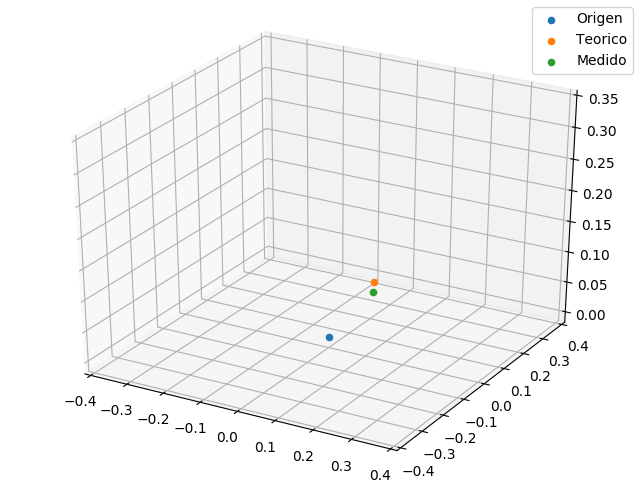

<IPython.core.display.Javascript object>


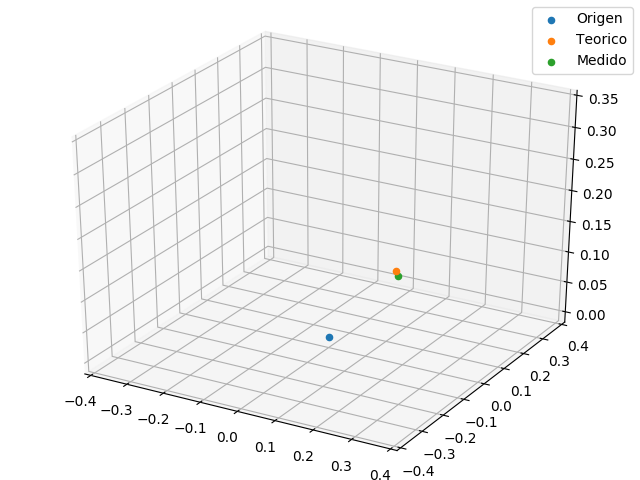

<IPython.core.display.Javascript object>


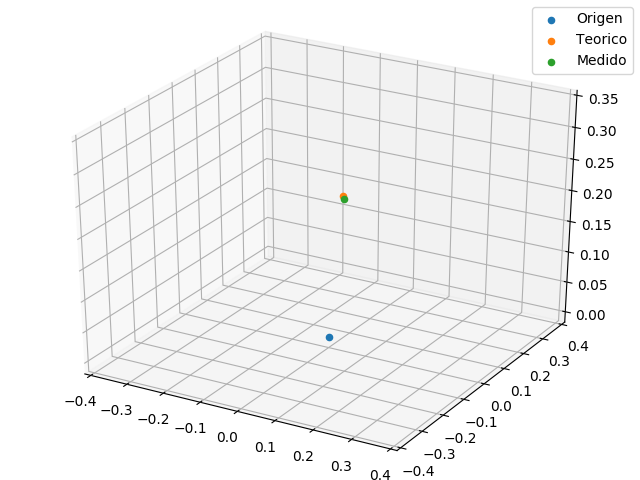

In [127]:
# Ejemplo, d es distancia (dx,dy,dz)
d = [0.5,0.8,1]
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

T0N = mr.FKinSpace(M, Slist, np.array(angles_list[0]))
T0N_medido = mr.FKinSpace(M, Slist, meas_angles_list[0] )
d_1 = T0N[:,3][:3]
d_1_medido = T0N_medido[:,3][:3]
fig_1 = plt.figure(1)
ax = Axes3D(fig_1)
plt.xlim(-0.4,0.4)
plt.ylim(-0.4,0.4)
ax.set_zlim(-0.01,0.35)
ax.scatter(0,0,0, label="Origen")
ax.scatter(d_1[0],d_1[1],d_1[2], label="Teorico")
ax.scatter(d_1_medido[0],d_1_medido[1],d_1_medido[2], label="Medido")
plt.legend()




T0N = mr.FKinSpace(M, Slist, np.array(angles_list[1]))
T0N_medido = mr.FKinSpace(M, Slist, meas_angles_list[1] )
d_2 = T0N[:,3][:3]
d_2_medido = T0N_medido[:,3][:3]

fig_2 = plt.figure(2)
ax = Axes3D(fig_2)
plt.xlim(-0.4,0.4)
plt.ylim(-0.4,0.4)
ax.set_zlim(-0.01,0.35)
ax.scatter(0,0,0, label="Origen")
ax.scatter(d_2[0],d_2[1],d_2[2], label="Teorico")
ax.scatter(d_2_medido[0],d_2_medido[1],d_2_medido[2], label="Medido")
plt.legend()


T0N = mr.FKinSpace(M, Slist, np.array(angles_list[2]))
T0N_medido = mr.FKinSpace(M, Slist, meas_angles_list[2] )
d_3 = T0N[:,3][:3]
d_3_medido = T0N_medido[:,3][:3]

fig_3 = plt.figure(3)
ax = Axes3D(fig_3)
plt.xlim(-0.4,0.4)
plt.ylim(-0.4,0.4)
ax.set_zlim(-0.01,0.35)
ax.scatter(0,0,0, label="Origen")
ax.scatter(d_3[0],d_3[1],d_3[2], label="Teorico")
ax.scatter(d_3_medido[0],d_3_medido[1],d_3_medido[2], label="Medido")
plt.legend()
plt.show()

### 5. Medir distancia entre realidad y teoría

#### Error en posicion 1

In [130]:
print("  x,y,z Teorico (mm):", d_1)
print("  x,y,z Medido:",d_1_medido)
print("  Error:",round(np.linalg.norm(d_1-d_1_medido)*1000, 4), "mm")

  x,y,z Teorico (mm): [2.42282825e-17 2.18228968e-01 4.00000000e-02]
  x,y,z Medido: [-0.0004983   0.21645932  0.02404097]
  Error: 16.0646 mm


#### Error en posicion 2

In [131]:
print("  x,y,z Teorico (mm):", d_2)
print("  x,y,z Medido:",d_2_medido)
print("  Error:",round(np.linalg.norm(d_2-d_2_medido)*1000, 4), "mm")

  x,y,z Teorico (mm): [0.1795 0.     0.1335]
  x,y,z Medido: [ 0.18349033 -0.00028162  0.12592647]
  Error: 8.5651 mm


#### Error en posicion 3

In [132]:
print("  x,y,z Teorico (mm):", d_3)
print("  x,y,z Medido:",d_3_medido)
print("  Error:",round(np.linalg.norm(d_3-d_3_medido)*1000, 4), "mm")

  x,y,z Teorico (mm): [ 0.08975    -0.08975     0.26042567]
  x,y,z Medido: [ 0.09445284 -0.09337183  0.25712958]
  Error: 6.7896 mm


## Subir *notebooks* a git

In [ ]:
subido=True